# Getting information from Scopus

**Note**: This work is obtained from http://kitchingroup.cheme.cmu.edu/blog/2015/04/03/Getting-data-from-the-Scopus-API/, its author is really the author of that information. I have mainly put in a more useful way.

The access to Scopus API is restricted. First, you need a Elseview-API. You can obtain one from http://dev.elsevier.com/myapikey.html. 

In my case, because I have access by a Proxy (and using a VPN, but it is transparent) I also need a PROXY_URL. That both information are not in the repository because they are personal and private. You should create your own my_scopus.py file to run that code without changes.

In [1]:
import requests
import json
from my_scopus import MY_API_KEY, PROXY_URL, MY_AUTHOR_ID

First, we define a function to access to the information

In [2]:
def print_json(resp_json):
    print(json.dumps(resp_json,
                 sort_keys=True,
                 indent=4, separators=(',', ': ')))

In [3]:
def scopus_get_info_api(url, proxy=PROXY_URL,*,verbose=False,json=True):
    """
    Returns the information obtained by the Elseview API
    """
    proxies = {
        "http": PROXY_URL
    }

    resp = requests.get("http://api.elsevier.com/content/" +url,
                    headers={'Accept':'application/json',
                             'X-ELS-APIKey': MY_API_KEY}, proxies=proxies)
    if verbose:
        print_json(resp.json())
    
    if json:
        return resp.json()
    else:
        return resp.text.encode('utf-8')

Then, a util function to show the information

A function that return the information of the author.

## Obtaining Author info

In [4]:
def scopus_get_author(author_id):
    msg = "author?author_id={}&view=metrics".format(author_id)
    resp = scopus_get_info_api(msg)
    return resp['author-retrieval-response'][0]

Example, to obtain my h-index

In [5]:
author_info = scopus_get_author(MY_AUTHOR_ID)
print_json(author_info)
h_index = author_info['h-index']
print("My automatic h_index is {}".format(h_index))

{
    "@_fa": "true",
    "@status": "found",
    "coauthor-count": "26",
    "coredata": {
        "citation-count": "1235",
        "cited-by-count": "1041",
        "dc:identifier": "AUTHOR_ID:22135567700",
        "document-count": "32",
        "prism:url": "http://api.elsevier.com/content/author/author_id/22135567700"
    },
    "h-index": "10"
}
My automatic h_index is 10


## Obtaining list of references

Now, we are going to extract the list of published papers.

In [6]:
def scopus_search_list(query, field, max=100, *, debug=False):
    msg = "search/scopus?query={}&nofield={}&count={}".format(query, field, max)
    
    if debug:
        print_json(scopus_get_info_api(msg))
        
    resp = scopus_get_info_api(msg)['search-results']
    list = []
    
    if resp['entry']:
        list = resp['entry']
        
    return list

In [7]:
def extract_info_papers(list):
    def get_type(code):
        if code in ['ar','re', 'ed', 'ip']:
            return 'article'
        elif code == 'cp':
            return 'congress'
        else:
            return code
        
    return [{'id': info['dc:identifier'], 
             'title': info['dc:title'], 
             'url': info['prism:url'], 
            'citations': int(info['citedby-count']), 
            'type': get_type(info['subtype']), 
             'year': info['prism:coverDate'][:4], 
            'journal': info['prism:publicationName']} for info in list]

In [8]:
def scopus_papers_from_author(author_id, *, max=100):
    """
    Return the list of papers from the author
    """
    query = "AU-ID({})".format(author_id)
    field = "dc:identifier"
    
    list = scopus_search_list(query, field, max)
    #print_json(list)
    return extract_info_papers(list)
    

In [9]:
papers = scopus_papers_from_author(MY_AUTHOR_ID)
print('{} papers'.format(len(papers)))

33 papers


## Translate to pandas

In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame.from_dict(papers)
print(df.head())

   citations                     id  \
0          0  SCOPUS_ID:84930999593   
1          2  SCOPUS_ID:84922590736   
2          0  SCOPUS_ID:84919727129   
3          4  SCOPUS_ID:84892553248   
4          0  SCOPUS_ID:84908587588   

                                             journal  \
0  International Journal of Computational Intelli...   
1                               Information Sciences   
2                     Applied Soft Computing Journal   
3                               Information Sciences   
4  Proceedings of the 2014 IEEE Congress on Evolu...   

                                               title      type  \
0  A Walk into Metaheuristics for Engineering Opt...   article   
1  A high performance memetic algorithm for extre...   article   
2  Performance evaluation of automatically tuned ...   article   
3  Region based memetic algorithm for real-parame...   article   
4  Influence of regions on the memetic algorithm ...  congress   

                               

### Ploting results

In [12]:
papers_journal = df[df['type']=='article']
citations = papers_journal.groupby(['year']).sum()

In [13]:
%pylab inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


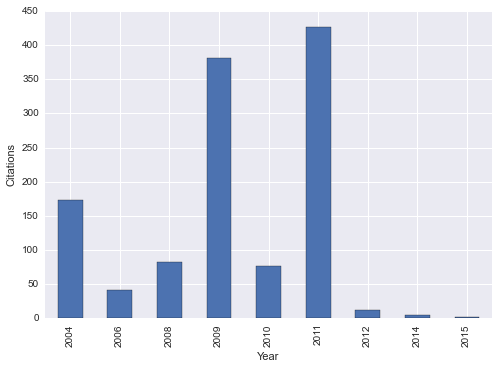

In [14]:
ax = citations.plot(kind='bar', legend=None)
ax.set_xlabel('Year')
ax.set_ylabel('Citations')

### Get complete reference of a paper

In [15]:
def get_scopus_info(SCOPUS_ID):
    url = ("abstract/scopus_id/"
          + SCOPUS_ID
          + "?field=authors,title,publicationName,volume,issueIdentifier,"
          + "prism:pageRange,coverDate,article-number,doi,citedby-count,prism:aggregationType")
    
    resp = scopus_get_info_api(url, json=True)
    results = resp['abstracts-retrieval-response']
    authors_info = results['authors']
    info = results['coredata']

    fstring = '{authors}, {title}, {journal}, {volume}, {articlenum}, ({date}). {doi} (cited {cites} times).\n'
    return fstring.format(authors=', '.join([au['ce:indexed-name'] for au in authors_info['author']]),
                          title=info['dc:title'],
                          journal=info['prism:publicationName'],
                          volume=info.get('prism:volume') or 1,
                          articlenum=info.get('prism:pageRange') or
                            info.get('article-number'),
                          date=info['prism:coverDate'],
                          doi='doi:' +(info.get('prism:doi') or 'NA'),
                        cites=int(info['citedby-count']))

df_lasts = df[df['year']=='2015']

for id in df.sort(['citations'], ascending=[0])['id']:
    #print("id: '{}'".format(id))
    print(get_scopus_info(id))

Garcia S., Molina D., Lozano M., Herrera F., A study on the use of non-parametric tests for analyzing the evolutionary algorithms' behaviour: A case study on the CEC'2005 Special Session on Real Parameter Optimization, Journal of Heuristics, 15, 617-644, (2009-12-01). doi:10.1007/s10732-008-9080-4 (cited 381 times).

Derrac J., Garcia S., Molina D., Herrera F., A practical tutorial on the use of nonparametric statistical tests as a methodology for comparing evolutionary and swarm intelligence algorithms, Swarm and Evolutionary Computation, 1, 3-18, (2011-03-01). doi:10.1016/j.swevo.2011.02.002 (cited 346 times).

Lozano M., Herrera F., Krasnogor N., Molina D., Real-coded memetic algorithms with crossover hill-climbing, Evolutionary Computation, 12, 273-302, (2004-09-01). doi:10.1162/1063656041774983 (cited 173 times).

Garcia-Martinez C., Lozano M., Herrera F., Molina D., Sanchez A.M., Global and local real-coded genetic algorithms based on parent-centric crossover operators, European 

## Get authors from a list

In [16]:
def get_author_info(paper_id):
    url = ("abstract/scopus_id/"
          + paper_id
          + "?field=authors,title,publicationName,volume,issueIdentifier,"
          + "prism:pageRange,coverDate,article-number,doi,citedby-count,prism:aggregationType")
    
    resp = scopus_get_info_api(url, json=True)
    results = resp['abstracts-retrieval-response']
    authors_info = results['authors']['author']
    authors_id = [au['ce:indexed-name'] for au in authors_info]
    return authors_id
    

In [55]:
from collections import defaultdict

def get_authors_list(papers_id):
    number = defaultdict(int)
    
    for i, paper_id in enumerate(papers_id):            
        authors = get_author_info(paper_id)
        
        for author in authors:
            number[author] += 1
            
    return number

authors = get_authors_list(df['id'])
print(authors)
    

defaultdict(<class 'int'>, {'Ortiz M.L.': 1, 'Liao T.': 3, 'Benitez J.M.': 3, 'Lozano M.': 17, 'Bello R.': 3, 'Xiong N.': 1, 'Montes De Oca M.A.': 1, 'Sanchez A.M.': 4, 'Herrera F.': 23, 'Stutzle T.': 3, 'Lastra M.': 1, 'Garcia-Martinez C.': 7, 'Garcia S.': 2, 'Marin J.': 1, 'Rodriguez F.J.': 1, 'Molina D.': 33, 'Triguero I.': 1, 'Aznarte J.L.': 2, 'Krasnogor N.': 1, 'Bergmeir C.': 1, 'Derrac J.': 1, 'Lacroix B.': 4, 'Herrer F.': 1, 'Dorigo M.': 1, 'de Oca M.A.M.': 1, 'Puris A.': 3})


In [56]:
def show_author_list(authors):
    names = authors.keys()
    names = sorted(names, key=lambda k: authors[k], reverse=True)

    for name in names:
        print("{}: {}".format(name, authors[name]))

In [57]:
show_author_list(authors = get_authors_list(df.id))

Molina D.: 33
Herrera F.: 23
Lozano M.: 17
Garcia-Martinez C.: 7
Sanchez A.M.: 4
Lacroix B.: 4
Liao T.: 3
Benitez J.M.: 3
Bello R.: 3
Stutzle T.: 3
Puris A.: 3
Garcia S.: 2
Aznarte J.L.: 2
Ortiz M.L.: 1
Xiong N.: 1
Montes De Oca M.A.: 1
Lastra M.: 1
Marin J.: 1
Rodriguez F.J.: 1
Triguero I.: 1
Krasnogor N.: 1
Bergmeir C.: 1
Derrac J.: 1
Herrer F.: 1
Dorigo M.: 1
de Oca M.A.M.: 1


## List of journals in which I have published

In [18]:
revistas = sorted(set(papers_journal['journal']))
for revista in revistas:
    print(revista)

Applied Soft Computing Journal
European Journal of Operational Research
Evolutionary Computation
Expert Systems with Applications
IEEE Transactions on Neural Networks and Learning Systems
Information Sciences
International Journal of Computational Intelligence Systems
Journal of Heuristics
Soft Computing
Swarm and Evolutionary Computation


## Searching by a criterion

In [69]:
def scopus_search_papers(words, type='ar'):
    """
    Return the list of papers from the author
    """
    query = "TITLE-ABS-KEY({}) AND PUBYEAR > 2010 AND DOCTYPE({})".format(words, type)
    field = "dc:identifier"
    
    list = scopus_search_list(query, field, 200)
    return extract_info_papers(list)  

In [68]:
results = scopus_search_papers("large scale optimization evolutionary")

In [66]:
papers_lsgo = pd.DataFrame.from_dict(results)
num_total = len(papers_lsgo)
print(sorted(set(papers_lsgo['year'])))

['2011', '2012', '2013', '2014', '2015']


## Get the number of journals with the results

In [21]:
lsgo_journal = papers_lsgo.groupby(['journal']).sum()
lsgo_journal.columns = ['number']
lsgo_journal = lsgo_journal.sort('number', ascending=False)
lsgo_journal = lsgo_journal[lsgo_journal['number']>0]

print(lsgo_journal)

                                                    number
journal                                                   
International Journal of Electrical Power and E...      27
Knowledge-Based Systems                                 26
IEEE Transactions on Evolutionary Computation           25
Energy                                                  22
Electric Power Systems Research                         19
Environmental Modelling and Software                    17
Soft Computing                                          17
Molecular Phylogenetics and Evolution                   15
Information Sciences                                    13
IEEE Transactions on Smart Grid                         12
International Journal of Hydrogen Energy                11
Applied Energy                                          10
Engineering Applications of Artificial Intellig...      10
Accounts of Chemical Research                            9
Applied Soft Computing Journal                          

In [22]:
papers_lsgo = papers_lsgo.sort('citations', ascending=False)
papers_lsgo = papers_lsgo[papers_lsgo['citations']>0]

for id in papers_lsgo['id'][:10]:
    print(get_scopus_info(id))

Wang L., Zheng X.-L., Wang S.-Y., A novel binary fruit fly optimization algorithm for solving the multidimensional knapsack problem, Knowledge-Based Systems, 48, 17-23, (2013-08-01). doi:10.1016/j.knosys.2013.04.003 (cited 25 times).

Srinivasa Reddy A., Vaisakh K., Shuffled differential evolution for large scale economic dispatch, Electric Power Systems Research, 96, 237-245, (2013-01-07). doi:10.1016/j.epsr.2012.11.010 (cited 17 times).

Paradis E., Molecular dating of phylogenies by likelihood methods: A comparison of models and a new information criterion, Molecular Phylogenetics and Evolution, 67, 436-444, (2013-05-01). doi:10.1016/j.ympev.2013.02.008 (cited 15 times).

Zhang X., Beeson P., Link R., Manowitz D., Izaurralde R.C., Sadeghi A., Thomson A.M., Sahajpal R., Srinivasan R., Arnold J.G., Efficient multi-objective calibration of a computationally intensive hydrologic model with parallel computing software in Python, Environmental Modelling and Software, 46, 208-218, (2013-08

Count the references and number for each author

In [60]:
show_author_list(authors = get_authors_list(papers_lsgo.id))

Wu J.: 5
Wang L.: 4
Chen Z.: 4
Wang Y.: 3
Yao X.: 3
Wang H.: 3
Yang Y.: 3
Bureerat S.: 3
Pholdee N.: 3
Chen T.: 2
Zhu Y.: 2
Sanches D.S.: 2
Ma L.: 2
Zheng C.: 2
Chen H.: 2
Wu F.: 2
Hadka D.: 2
Dokeroglu T.: 2
Li Y.: 2
Wang W.: 2
Sabourin R.: 2
Liu W.: 2
Ma H.: 2
Wang J.: 2
Jiang H.: 2
Zhuang J.: 2
Cosar A.: 2
Roy P.K.: 2
Basu M.: 2
Delbem A.C.B.: 2
Tang Y.: 2
Sun X.: 2
Granger E.: 2
Desa M.I.: 1
Zhang H.: 1
de Athayde Costa e Silva M.: 1
Thomas S.A.: 1
Zhu L.: 1
Qiu W.: 1
Chen M.-R.: 1
Ahmadi A.: 1
Peng C.: 1
Li G.: 1
Kim D.-K.: 1
Link R.: 1
Nee A.Y.C.: 1
Tian C.H.: 1
Rundel P.: 1
Georgiev P.G.: 1
Tino P.: 1
Wang Z.: 1
Hartke B.: 1
Wen J.: 1
Zaim A.H.: 1
Klein C.E.: 1
Cui Z.: 1
Fang T.: 1
Cao Y.: 1
Saunders M.: 1
Li B.: 1
Tao F.: 1
Jin Y.: 1
Ma T.: 1
Vellasques E.: 1
Kurkalova L.A.: 1
Huang K.C.: 1
Kwon H.-C.: 1
Ye W.: 1
Rahim N.A.: 1
Yuan X.: 1
Hao Z.: 1
Dong W.: 1
Yuan B.: 1
Austern G.: 1
Prado R.S.: 1
Zhao S.-Z.: 1
Sahajpal R.: 1
Andrade C.: 1
Beeson P.: 1
Escalante H.J.: 1
Li Q.: 1

## For Congress

In [70]:
results_cp = scopus_search_papers("large scale optimization evolutionary", type='cp')
results = pd.DataFrame.from_dict(results_cp)
show_author_list(authors = get_authors_list(results.id))


Sanches D.S.: 6
El-Hawary M.E.: 6
Delbem A.C.B.: 6
Farhat I.A.: 6
London J.B.A.: 4
Wang Y.: 4
Li X.: 4
Das S.: 4
Essam D.: 3
Wei F.: 3
Kazimipour B.: 3
Sarker R.: 3
Zhou Z.: 3
Li J.: 3
Wang X.: 3
Qin A.K.: 3
Wang J.: 3
Sayed E.: 3
Li B.: 2
Pena J.-M.: 2
Li H.: 2
Ludwig S.A.: 2
Yao X.: 2
Guimaraes F.G.: 2
Lu Y.: 2
Marechal F.: 2
Omidvar M.N.: 2
Muelas S.: 2
Zeng Y.: 2
Zhang G.: 2
Schaul T.: 2
Fister I.: 2
Deepan Babu P.: 2
Amudha T.: 2
Rajasekhar A.: 2
Satapathy S.K.: 2
Zong T.: 2
Nishihara S.: 2
Tang K.: 2
Chiba K.: 2
Mizuno K.: 2
Yang Y.: 2
Aratsu Y.: 2
Qi J.: 2
Tang M.: 2
Liu Y.: 2
Santos A.C.: 2
Feng H.: 2
Brest J.: 2
Gois M.M.: 2
Sasaki H.: 2
Landa R.: 2
Li Z.: 2
Rojas Y.: 2
Mazucato S.C.: 1
Zelinka I.: 1
Talebi H.: 1
Oliveri G.: 1
Kaiquan C.: 1
Liang N.: 1
Afshar A.: 1
Castoldi M.F.: 1
Trunfio G.A.: 1
Bramerdorfer G.: 1
Li Z.Y.: 1
Pedroni N.: 1
Das A.K.: 1
Sakai S.: 1
Izzo D.: 1
Rigoni E.: 1
Huang A.: 1
Moret B.M.E.: 1
Bawa S.: 1
Xiaobo X.: 1
Zhang N.: 1
Grundmann J.: 1
Xiong S.: 

In [72]:
results_cp = scopus_search_papers("large scale optimization differential evolution", type='cp')
results = pd.DataFrame.from_dict(results_cp)
show_author_list(authors = get_authors_list(results.id))

Yang Y.: 2
Wang L.: 2
Wang H.: 2
Li J.: 2
Li H.: 2
Chiba K.: 2
Landa R.: 2
Wu Z.: 2
Wang X.: 2
Rojas Y.: 2
Kazimipour B.: 1
Arellano-Verdejo J.: 1
Boskovic B.: 1
Skalna I.: 1
Fernandes E.M.G.P.: 1
Yuan Y.: 1
Bolufe-Rohler A.: 1
Lian L.: 1
Jia G.: 1
Pham H.: 1
Xi Z.: 1
Trunfio G.A.: 1
Li G.: 1
Hsieh S.-T.: 1
Sharma H.: 1
Pedroni N.: 1
Karunanithi K.: 1
Prado R.S.: 1
Sakai S.: 1
Neri F.: 1
Birkholzer J.: 1
Rajasekhar A.: 1
Huang A.: 1
Xiaobo X.: 1
Tonutti P.: 1
Rajakumar B.R.: 1
Wei F.: 1
Yen S.-J.: 1
Chen S.: 1
Li X.: 1
Peng L.: 1
Barron-Fernandez R.: 1
Duda J.: 1
Rodriguez-Vazquez J.J.: 1
Das A.K.: 1
Majumdar R.: 1
He D.: 1
Qin A.K.: 1
White T.: 1
He Y.-J.: 1
Taud H.: 1
Sun H.J.: 1
Zong T.: 1
Affijulla S.: 1
Cardenas-Montes M.: 1
Maucec M.S.: 1
Wang J.: 1
Toscano-Pulido G.: 1
Zhao S.-Z.: 1
Zamuda A.: 1
Das S.: 1
Li Y.B.: 1
Bansal J.C.: 1
Chiou J.-P.: 1
Sanches D.S.: 1
Polonen H.: 1
Sun J.: 1
Shu J.: 1
Schaar J.E.: 1
Stanarevic N.: 1
Zhou X.: 1
Bui T.: 1
Lauze F.: 1
Bianchi M.: 1
Turan 

In [77]:
results = results.sort(['citations'], ascending=False)
for id in results.id[:10]:
    print(get_scopus_info(id))

Wang H., Rahnamayan S., Wu Z., Adaptive Differential Evolution with variable population size for solving high-dimensional problems, 2011 IEEE Congress of Evolutionary Computation, CEC 2011, 1, 2626-2632, (2011-08-29). doi:10.1109/CEC.2011.5949946 (cited 5 times).

Kazimipour B., Li X., Qin A.K., Effects of population initialization on differential evolution for large scale optimization, Proceedings of the 2014 IEEE Congress on Evolutionary Computation, CEC 2014, 1, 2404-2411, (2014-01-01). doi:10.1109/CEC.2014.6900624 (cited 2 times).

Chiba K., Evolutionary hybrid computation in view of design information by data mining, 2013 IEEE Congress on Evolutionary Computation, CEC 2013, 1, 3387-3394, (2013-08-21). doi:10.1109/CEC.2013.6557985 (cited 2 times).

Azad Md.A.K., Fernandes E.M.G.P., Modified differential evolution based on global competitive ranking for engineering design optimization problems, Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intell